In [1]:
import numpy as np
import json

In [2]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
# load json file
with open('./data/train.json') as data_file:
    data = json.load(data_file)

In [7]:
print(data[0])
print(len(data))

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}
39774


In [27]:
# getting the number of occurences of the amount of times an ingredient occured in a cusine
# storing it in a martix cell as [cuisine, ingredient]
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        # gets the cusine
        cuisine = json[i]['cuisine']
        
        # gets a list of ingredients in that cuisine
        ingredientsPerCuisine = json[i]['ingredients']
        #  add to growing list of ingredients       
        ingredients.extend(ingredientsPerCuisine)
        
        # if new cusine is found then add it to dictionary
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            # add the new ingredients to it
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
        else:
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            
    ingredients = list(set(ingredients))
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    #     return values
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients

In [28]:
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    # create a matrix for the number of cusines as its rows 
    # and the number of ingredients as it columns
    termCountMatrix = np.zeros((numCuisines,numIngred))
    
    # row: each cuisine, col: each ingredient
    for row, cuisine in enumerate(cuisines):
        ingredientsPerCuisine = dictCuisineIngred[cuisine]
        for ingredient in ingredientsPerCuisine:
            
            col = ingredients.index(ingredient)
            termCountMatrix[row, col] += 1
            
    return termCountMatrix        

In [29]:
dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)

In [30]:
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/sparse.html
from scipy import sparse
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

In [31]:
get_ipython().magic(u'matplotlib inline')

In [32]:
# using the countsMatrix we created earlier we can now make tf-idf matrix
#  tf-idf matrix: will normalize a count matrix
def tf_idf_from_count_matrix(countsMatrix):
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    
    # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf = transformer.fit_transform(countsMatrix)
    tfidf.toarray() 
    return tfidf.toarray()    

In [33]:
# creating the tf-idf matrix
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)

In [36]:
# running PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfIdf_Matrix)

In [43]:
# converting to pandas dataframe for convenience
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2'] # rename columns

In [47]:
pca2dataFrame.tail()

,PC1,PC2
15,0.467967,0.227678
16,-0.319051,0.391703
17,0.560471,0.141743
18,-0.176450,-0.402093
19,-0.264449,0.303534


In [52]:
from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

In [150]:
labels = kmeans_cultures(3)

In [151]:
print(len(reduced_data), len(labels))
print(labels) # predictions of 20 labels and which cluster they belong to 

20 20
[0 2 1 0 0 0 0 0 1 2 1 1 0 0 2 1 2 1 0 2]


In [152]:
effect_on_cluster = [0 for cuisine in cuisines]
i = 0 
j = 0 
for cuisineA in cuisines:  
    # intersection with cusine
    A_intersection = 0
    # 
    numInClusterBesidesA = 0
    # set of ingredients for that cuisine
    setA = set(dictCuisineIngred[cuisineA])
    # 
    setB_forA = []
    
    j= 0
    
    for cuisineB in cuisines:
        # compare every other cusine with and expect the itself
        if cuisineB != cuisineA:
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                # if in same cluster then add to set
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j+=1 
        
    # ???#number of intersection of two sets / number of total sets
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection # ???
    
    i+=1
            

In [153]:
print(effect_on_cluster)

[0.21818181818181817, 0.4278336504484914, 0.2506443298969072, 0.2656126482213439, 0.16126482213438736, 0.233201581027668, 0.42727272727272725, 0.4007905138339921, 0.4333118556701031, 0.2737156836096765, 0.3704896907216495, 0.3173324742268041, 0.27213438735177864, 0.15276679841897234, 0.41967926066865996, 0.3540592783505155, 0.24707801032889373, 0.25128865979381443, 0.1816205533596838, 0.2082087523783637]


In [154]:
import matplotlib.pyplot as plt
from pylab import text

In [155]:
rdata = reduced_data
i=0
figureRatios = (15,15)

In [156]:
x = []
y = []
color = []
area = []

In [159]:
#creating a color palette:
colorPalette = [ '#e6194b','#3cb44b','#00e119','#0082c8','#f58231',
                            '#911eb4','#46f0f0','#f032e6','#d2f53c','#fabebe',
                            '#008080','#e6beff','#aa6e28','#800000','#000080',
                            '#808080','#46f0f0','#f58231','#911eb4','#808000',
    ] # for number of clusters

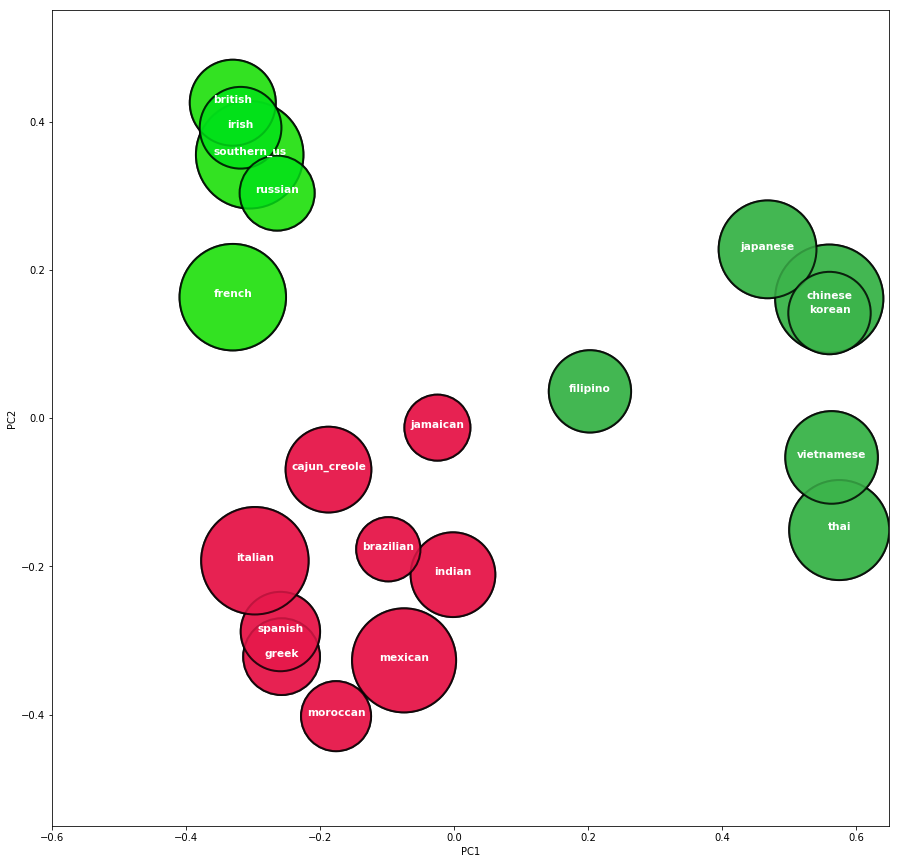

<Figure size 432x288 with 0 Axes>

In [160]:
i=0
plt.figure(1, figsize=figureRatios)
for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1
    
plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='k', alpha=0.80) 

plt.axis([-0.6,0.65,-0.55,0.55])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.savefig('./graphs/kmeans_3_comparison.png')

In [161]:
labels = kmeans_cultures(10)
# numCuisines

In [162]:
effect_on_cluster = [0 for cuisine in cuisines]
i = 0 
j = 0 
for cuisineA in cuisines:  
    # intersection with cusine
    A_intersection = 0
    # 
    numInClusterBesidesA = 0
    # set of ingredients for that cuisine
    setA = set(dictCuisineIngred[cuisineA])
    # 
    setB_forA = []
    
    j= 0
    
    for cuisineB in cuisines:
        # compare every other cusine with and expect the itself
        if cuisineB != cuisineA:
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                # if in same cluster then add to set
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j+=1 
        
    # ???#number of intersection of two sets / number of total sets
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection # ???
    
    i+=1

In [163]:
rdata = reduced_data
figureRatios = (15,15)

In [164]:
x = []
y = []
color = []
area = []

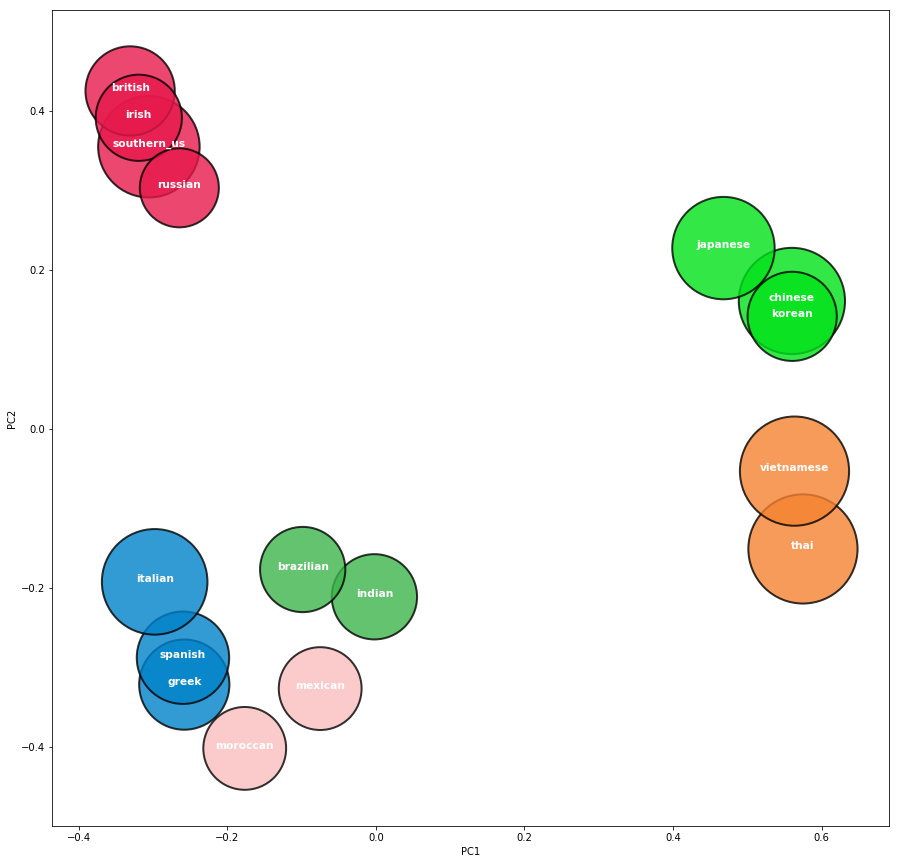

<Figure size 432x288 with 0 Axes>

In [165]:
i=0
plt.figure(1, figsize=figureRatios)
for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1
    
plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='k', alpha=0.80) 

# plt.axis([-0.6,0.65,-0.55,0.55])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.savefig('./graphs/kmeans_14_comparison.png')